# Problem Set 9
## Daryl Larsen
### Question 3 - Monte Carlo simulations for the efficient two-step GMM estimator

In [1]:
using Random, Distributions, PrettyTables, Printf, Plots, Optim, ForwardDiff
Random.seed!(20220401)

MersenneTwister(20220401)

#### (a) Generate n observations from model

In [2]:
const θ_0 = 5.0
const λ = 0.9

0.9

In [3]:
function Λ(X,θ)
    Λ = 2 * (1 .+ exp.(5 .- θ .* X)).^(-1)
    return Λ = Λ
end

Λ (generic function with 1 method)

In [4]:
function data(n)
    Z1 = rand(Normal(2,1),n)
    Z2 = rand(Normal(-2,1),n)
    V = rand(Normal(0,1),n)
    ϵ = rand(Normal(0,1),n)
    
    U = λ * V + ϵ
    X = exp.(Z1 + Z2) + V
    
    Y = Λ(X, θ_0) + U
    
    return (Y = Y, X = X, Z1 = Z1, Z2 = Z2)
end

data (generic function with 1 method)

#### (b) Compute GMM criterion function

In [5]:
function Qn(Y, X, Z1, Z2, θ, A)
    n = length(Y)
    Z = [Z1 Z2]
    U = Y - Λ(X,θ)
    
    Qn = 1/2 * (Z' * U/n)' * A * Z' * U/n
    
    return Qn = Qn
end

Qn (generic function with 1 method)

#### (c) Generate $10^5$ observations and plot the criterion function using $A_n^\prime A_n = I$

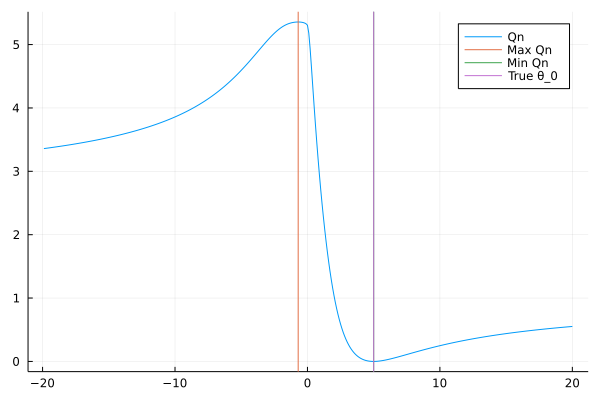

In [6]:
A = [1 0; 0 1]
n = 10^5

result = zeros((400,2))
(Y, X, Z1, Z2) = data(n)
for i in 1:400
    θ_i = -20 + 0.1 * i
    result[i,1] = Qn(Y, X, Z1, Z2, θ_i, A)
    result[i,2] = θ_i
end

plot(result[:,2], result[:,1], label = "Qn")
vline!([result[argmax(result[:,1]),2]], label = "Max Qn")
vline!([result[argmin(result[:,1]),2]], label = "Min Qn")
vline!([5.0], label = "True θ_0")
#print(result[argmin(result[:,1]),2])

The criterion function correctly identifies $\theta_0$, as the minimum value comes almost exactly at 5.

#### (d) Compute GMM estimator using -5, 0, and 20 as starting values

In [7]:
A = [1 0; 0 1]
n = 10^5

(Y, X, Z1, Z2) = data(n)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [-5.0], NewtonTrustRegion(); autodiff = :forward)
θ_1 = Optim.minimizer(result)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [0.0], NewtonTrustRegion(); autodiff = :forward)
θ_2 = Optim.minimizer(result)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [20.0], NewtonTrustRegion(); autodiff = :forward)
θ_3 = Optim.minimizer(result)


print(θ_1, θ_2, θ_3)

[-5.0][5.042026284096013][5.042026284096277]

If we start at -5, the minimization algorithm also returns -5, but starting at 0 and 20 both returned something very close to the true value as before. 

#### (e) Show how asymptotic variance of the efficient GMM estimator can be consistently estimated using $\partial^2Q_n^*(\hat\theta_n)/\partial\theta\partial\theta^\prime$

With an efficient weighting matrix, we have that
$$
A_n^{*\prime}A_n^* \rightarrow_p A^{*\prime}A^*=(E[g(W_i,\theta_0)g(W_i,\theta_0)^\prime])^{-1}=\Omega_0^{-1}
$$
Then
$$\begin{align}
\frac{\partial^2Q_n^*(\theta_0)}{\partial\theta\partial\theta^\prime} &= \left[\frac{1}{n}\sum_{i=1}^n\frac{\partial g(W_i,\theta_0)}{\partial\theta^\prime}\right]^\prime A_n^{*\prime}A_n^*\left[\frac{1}{n}\sum_{i=1}^n\frac{\partial g(W_i,\theta_0)}{\partial\theta^\prime}\right]+\left[\frac{1}{n}\sum_{i=1}^n\frac{\partial^2g(W_i,\theta_0)}{\partial\theta\partial\theta\prime}\right]^\prime A_n^{*\prime}A_n^*\left[\frac{1}{n}\sum_{i=1}^ng(W_i,\theta_0)\right] \\
&\rightarrow_pE\left[\frac{\partial g(W_i,\theta_0)}{\partial\theta^\prime}\right]^\prime A^{*\prime}A^*E\left[\frac{\partial g(W_i,\theta_0)}{\partial\theta^\prime}\right] \\
&= \Gamma_0^\prime\Omega_0^{-1}\Gamma_0 \\
&= V_0^{-1}
\end{align}$$
Then since we have a consistent estimator for $\theta_0$,
$$\begin{align}
\left(\frac{\partial^2Q_n^*(\hat{\theta}_n)}{\partial\theta\partial\theta^\prime}\right)^{-1} &= \left(\frac{\partial^2Q_n^*(\theta_0)}{\partial\theta\partial\theta^\prime}+\frac{\partial^3Q_n^*(\theta_0)}{\partial\theta\partial\theta^\prime\partial\theta^\prime}(\hat{\theta}_n-\theta_0)\right)^{-1} \\
&\rightarrow_pV_0
\end{align}$$

#### (f) Compute two-step efficient GMM estimator given data

In [8]:
function TwoStepEffGMM(Y, X, Z1, Z2)
    A = [1 0; 0 1]
    n = length(Y)
    result1 = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [0.0], NewtonTrustRegion(); autodiff = :forward)
    θ_1 = Optim.minimizer(result1)[1]

    Z = [Z1 Z2]
    U = Y - Λ(X,θ_1)
    ZU = Z .* U

    A1 = (ZU' * ZU) /n
    A1 = inv(A1)

    result2 = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A1), [θ_1], NewtonTrustRegion(); autodiff = :forward)
    θ_2 = Optim.minimizer(result2)[1]

    f(θ) = Qn(Y, X, Z1, Z2, θ, A1)
    V = ForwardDiff.hessian(f, [θ_2])[1]
    V = V^(-1)

    return (θ_2 = θ_2, V = V)
end

TwoStepEffGMM (generic function with 1 method)

#### (g) Simulate coverage probabilities of the confidence interval for $\theta_0$ based on efficient GMM estimator

In [9]:
R = 10^4
cover = zeros(3)
for i in 1:R
    (Y, X, Z1, Z2) = data(200)
    (θ, V)  = TwoStepEffGMM(Y, X, Z1, Z2)
    cover[1] += (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.1/2) * sqrt(V/200)) /R
    cover[2] += (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.05/2) * sqrt(V/200)) /R
    cover[3] += (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.01/2) * sqrt(V/200)) /R
end

header = ["α: 0.1", "α: 0.05", "α: 0.01"]
cover = cover'
pretty_table(cover; header = header)

┌────────┬─────────┬─────────┐
│ α: 0.1 │ α: 0.05 │ α: 0.01 │
├────────┼─────────┼─────────┤
│ 0.9094 │  0.9433 │  0.9777 │
└────────┴─────────┴─────────┘


The simulated coverage probability for $\alpha=0.05$ is very close to the expected value, but the probabilities at the ends are farther away. Still, they're within reasonable range.